In [1]:
# Get timings for each cell
%load_ext autotime

In [2]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip, sigma_clipped_stats

from ccdproc import ImageFileCollection, Combiner, CCDData

from scipy import fftpack
from scipy import stats

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.offsetbox as offsetbox
from matplotlib import pyplot as plt

plt.style.use('bmh')

from tqdm import tqdm  # Progress bars

from piaa.utils import helpers
from pong.utils import storage
from piaa.utils.plot import pixel_hist

time: 2.13 s


### Get the calibration images

Download the files from google storage buckets. 

In [3]:
# Get our calibration images for the unit
calibration_images = storage.get_observation_blobs('PAN001/calibration/')
len(calibration_images)

482

time: 316 ms


In [4]:
# Save FITS files to this location
local_save_dir = '/var/panoptes/images/flats'
os.makedirs(local_save_dir, exist_ok=True)

time: 1.21 ms


In [5]:
# !!!WARNING - Download from the google storage buckets - lots of data - WARNING!!!
file_list = list()
for fn in tqdm(calibration_images):
    local_fn = storage.download_fits_file(fn, save_dir=local_save_dir, unpack=False)
    file_list.append(local_fn)

100%|██████████| 482/482 [00:00<00:00, 34426.96it/s]

time: 18.8 ms


In [6]:
camera_id = 'ee04d1'

time: 702 µs


In [7]:
# Get the local path names
bias_list = [fn for fn in file_list if '{}_bias'.format(camera_id) in fn][0:100]

len(bias_list)

100

time: 4.62 ms


In [8]:
images = ImageFileCollection(
    location=local_save_dir, 
    filenames=bias_list,
    ext=1)

time: 2.99 s


In [9]:
len(images.files)

100

time: 3.66 ms


In [10]:
# Build up a master bias data set
bias_list = []
for hdu, fname in tqdm(images.hdus(return_fname=True), total=len(images.files)):
    meta = hdu.header
    meta['filename'] = fname
    bias_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

time: 46.6 s


In [11]:
# Combine using average
biases = Combiner(bias_list)
master_bias = biases.average_combine()

time: 1min 39s


In [12]:
master_bias_fn = '/var/panoptes/images/pan001-{}-master-bias.fits'.format(camera_id)

time: 991 µs


Read or write the master bias frame

In [13]:
# Write new master bias
master_bias.write(master_bias_fn, overwrite=True)

time: 352 ms


In [14]:
# Read existing master bias
master_bias = CCDData(data=fits.getdata(master_bias_fn).astype(np.float32), unit='adu')

time: 104 ms


#### Examine Master Bias

In [15]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

time: 1.27 ms


In [16]:
bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(master_bias))

time: 178 ms


In [17]:
bias_props = """Count:{:10d}
Min:  {:10.02f}
Max:  {:10.02f}
Mean: {:10.02f}
Std:  {:10.02f}
""".format(
    len(master_bias.data.flatten()),
    bias_min, bias_max,
    bias_mean, bias_std,
)

time: 62.7 ms


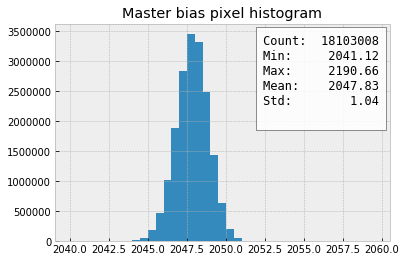

time: 1.52 s


In [18]:
# Histogram of pixels. 'step' type is ugly but way faster.
bins = plt.hist(master_bias.data.flatten(), 
                histtype='bar', 
                bins=np.arange(2040, 2060, 0.5),
)
plt.title('Master bias pixel histogram')

ob = offsetbox.AnchoredText(bias_props, loc=1, prop=dict(size=12, family="monospace"))
ob.patch.set(boxstyle='square,pad=0.2', alpha=0.85)
plt.gca().add_artist(ob)
plt.savefig(
    '/var/panoptes/images/pan001-{}-master-bias-hist.png'.format(camera_id), 
    transparent=False
)

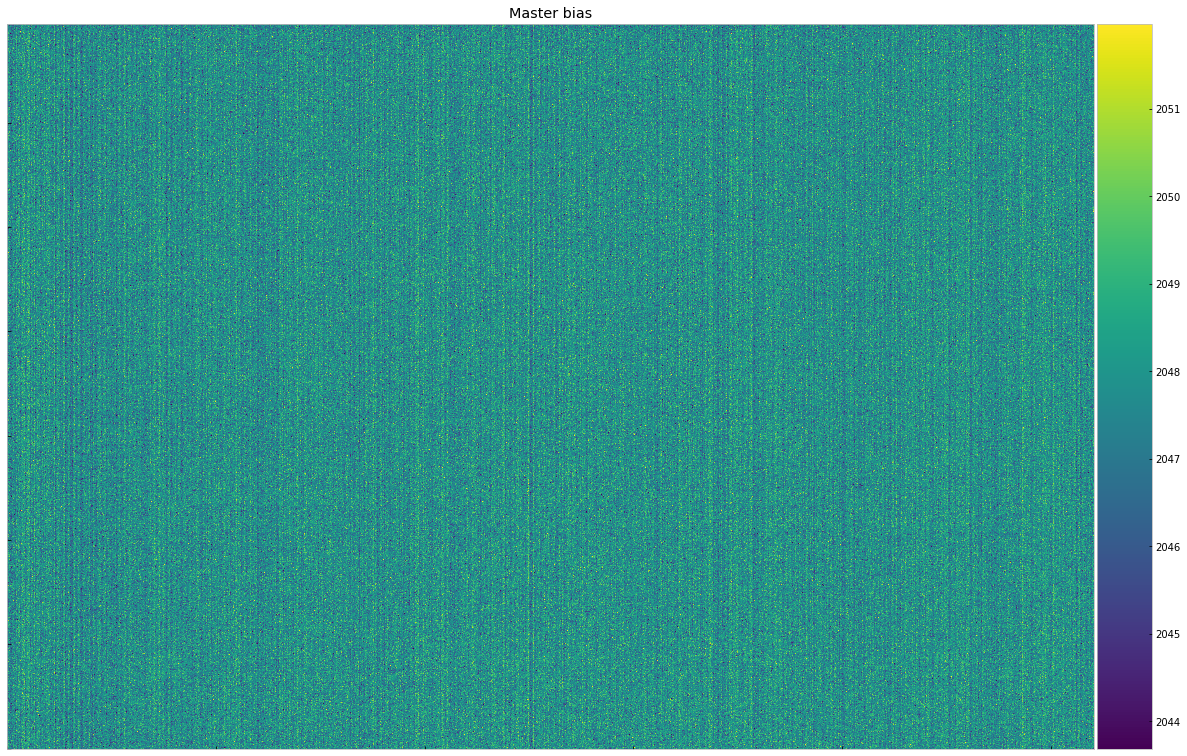

time: 3.27 s


In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(master_bias, vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)
ax.set_title('Master bias')
ax.grid(False)

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()
fig.set_size_inches(fig.get_size_inches() * 3)

fig.savefig('/var/panoptes/images/pan001-{}-master-bias.png'.format(camera_id), transparent=False)

/home/wtylergee/miniconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


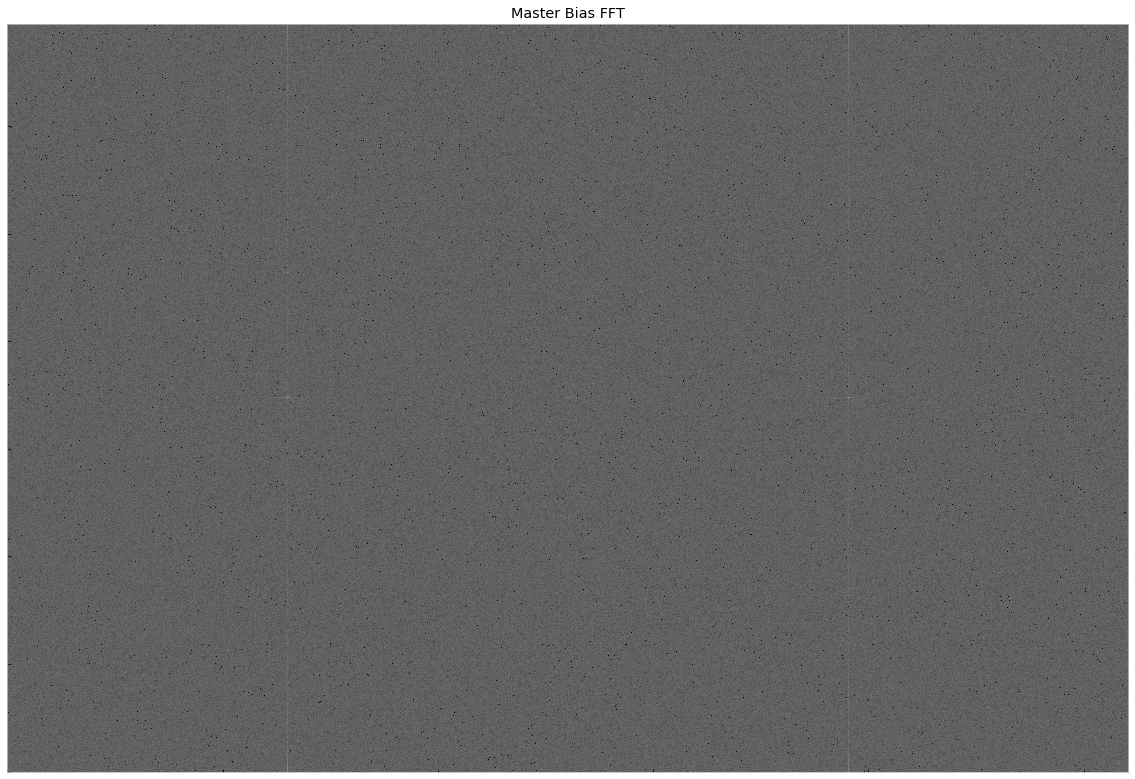

time: 6.66 s


In [20]:
# FFT
f0 = fftpack.fft2(master_bias.data)

fig = plt.figure()

ax = fig.add_subplot(111)

ax.imshow(np.abs(f0), cmap='Greys_r', norm=LogNorm())
ax.set_title('Master Bias FFT')
ax.grid(False)

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()    
fig.set_size_inches(fig.get_size_inches() * 3)

fig.savefig(
    '/var/panoptes/images/pan001-{}-master-bias-fft.png'.format(camera_id), 
    transparent=False
)

## Readnoise

In [21]:
readnoise = np.array([np.array(master_bias.data - ccd.data).std() for ccd in bias_list])

time: 18.5 s


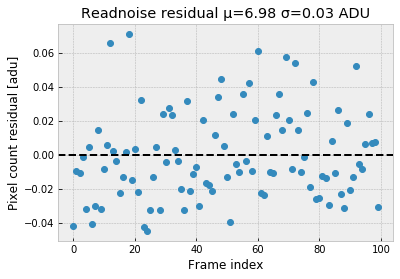

time: 279 ms


In [22]:
plt.plot(readnoise - readnoise.mean(), ls='', marker='o')
plt.axhline(0, c='k', ls='--')
plt.ylabel('Pixel count residual [adu]')
plt.xlabel('Frame index')
plt.title('Readnoise residual μ={:.02f} σ={:.02f} ADU'.format(readnoise.mean(), readnoise.std()))
plt.savefig(
    '/var/panoptes/images/pan001-{}-readnoise-frame-hist.png'.format(camera_id), 
    transparent=False
)

In [23]:
read0 = master_bias.data - bias_list[5]

time: 2.07 s


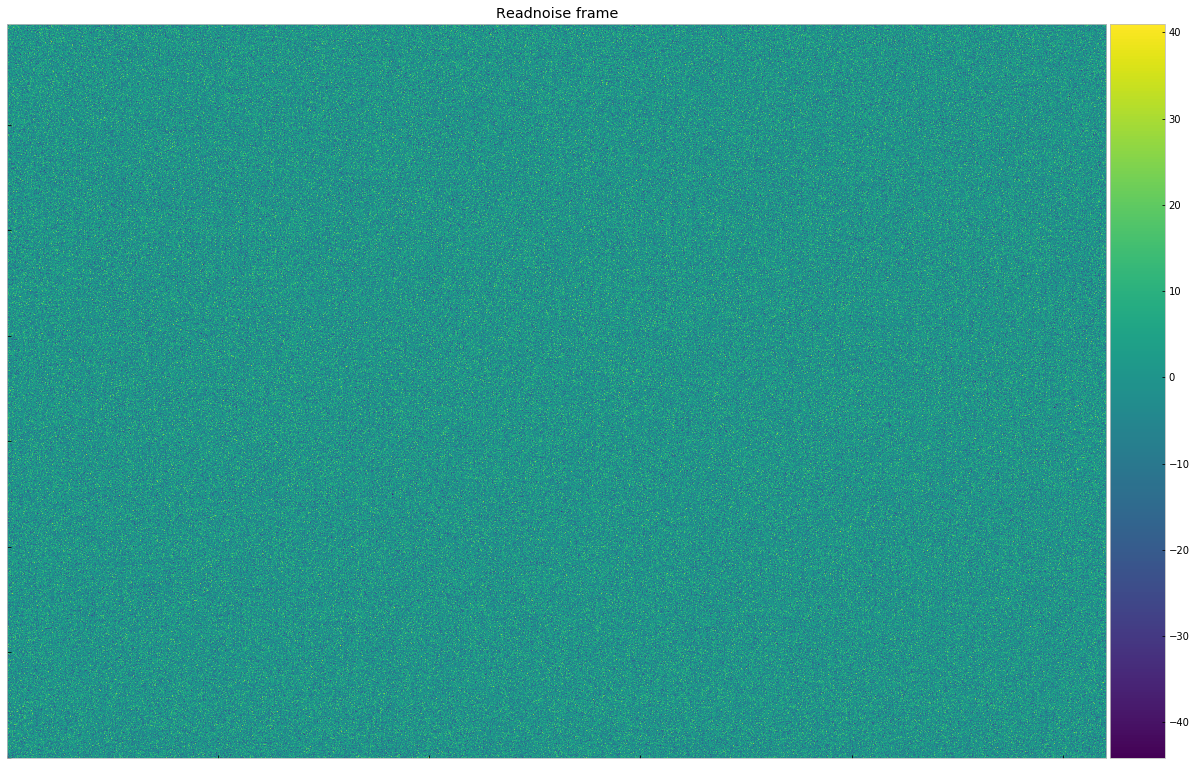

time: 3.34 s


In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(read0)
ax.set_title('Readnoise frame')
ax.grid(False)

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()
fig.set_size_inches(fig.get_size_inches() * 3)

fig.savefig(
    '/var/panoptes/images/pan001-{}-readnoise-frame.png'.format(camera_id),
            transparent=False)

/home/wtylergee/miniconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


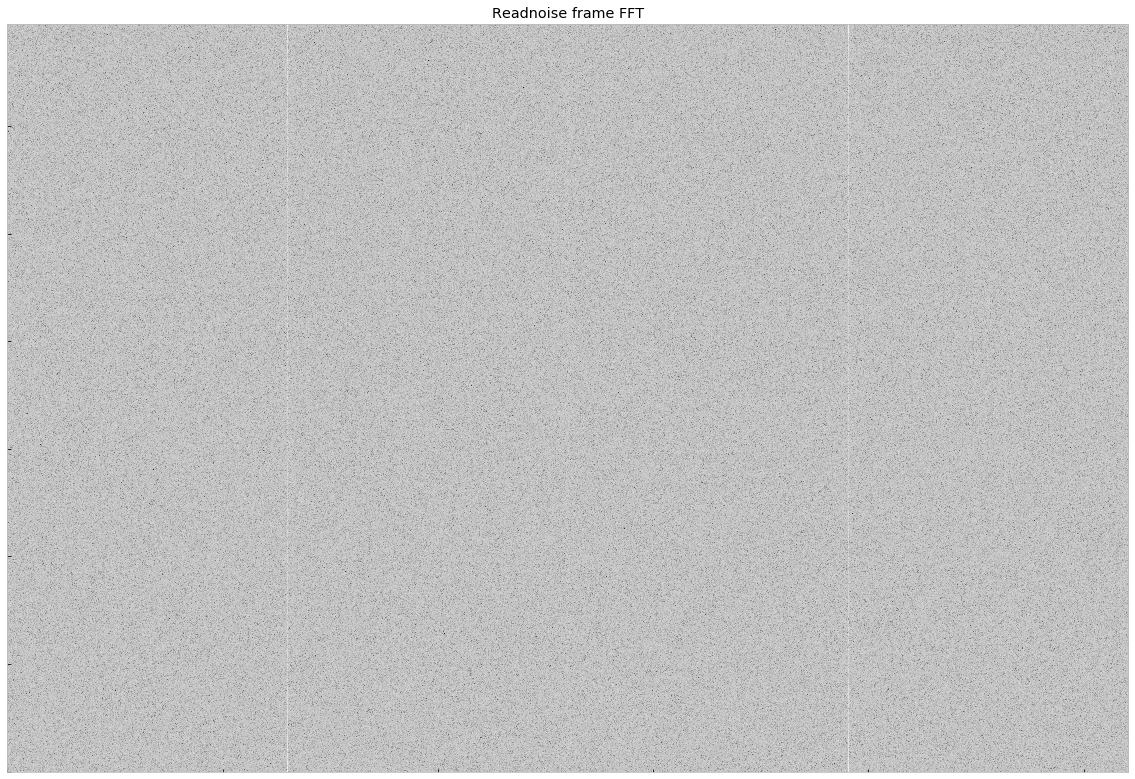

time: 6.94 s


In [25]:
# FFT
f0 = fftpack.fft2(read0)

fig = plt.figure()

ax = fig.add_subplot(111)

ax.imshow(np.abs(f0), cmap='Greys_r', norm=LogNorm())
ax.set_title('Readnoise frame FFT')
ax.grid(False)

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()    
fig.set_size_inches(fig.get_size_inches() * 3)

fig.savefig('/var/panoptes/images/pan001-{}-readnoise-frame-fft.png'.format(camera_id),
            transparent=False)